In [90]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.mc_sfs import *
from cfollmer.drifts import SimpleForwardNet, SimpleForwardNetBN, ResNetScoreNetwork,AbstractDrift
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )
        
    def forward(self, x):
        return self.nn(x)

    
class LinModel(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(LinModel, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 1),
        )
        
    def forward(self, x):
        return self.nn(x)

In [9]:



def predict(param_samples, x, y, size_list=None):
    with torch.no_grad():
        predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
        predict_func = functorch.vmap(predict_func)

        preds = predict_func(param_samples) # {<w_s , x>}_s
        # Var(w* x + e) = Var(w*x) + Var(e) =  Var(w*x) + sigma_n*2
        std, mean = torch.std_mean(preds, dim=0)
        mse = torch.mean((y_test - mean)**2)
        logp = torch.mean(log_likelihood_batch(x, y, param_samples, size_list=size_list))
        
    return std, mean, logp, mse

## Bayesian Linear Regression Closed Form Predictive

![image info](../images/blr.PNG)


Below we implment the above formulas

In [5]:
def pred_true_std(X_train, X_test, sigma_n, sigma2, dim):
    # https://github.com/probml/pml-book/releases/latest/download/book1.pdf
    # See Eq 11.124 in the above link page 430 on pdf viewer (page 400 on page number in pdf)

    X_trainnp = X_train.cpu().detach().numpy()
    n_, d = X_trainnp.shape

    X_trainnp = np.concatenate((X_trainnp, np.ones((n_, 1))), axis=1)

    X_testnp = X_test.cpu().detach().numpy()
    n_, d = X_testnp.shape

    X_testnp = np.concatenate((X_testnp, np.ones((n_, 1))), axis=1)


    Sigma_post = sigma_n**2 * np.linalg.inv(sigma_n**2 *  np.eye(dim) / sigma2 + np.dot(X_trainnp.T,X_trainnp))
    
    sigma_pred = []
    for i in range(n_):
        sigma_pred += [np.dot(X_testnp[i,:].dot(Sigma_post), X_testnp[i,:]) + sigma_n**2 ]

    std_true = np.sqrt( sigma_pred)
    return std_true


def pred_true_mean(y_train, X_train, X_test, sigma_n, sigma2, dim):
    # https://github.com/probml/pml-book/releases/latest/download/book1.pdf
    # See Eq 11.124 in the above link page 430 on pdf viewer (page 400 on page number in pdf)

    X_trainnp = X_train.cpu().detach().numpy()
    n_, d = X_trainnp.shape
    
    lambda_ = sigma_n**2 / sigma2 

    X_trainnp = np.concatenate((X_trainnp, np.ones((n_, 1))), axis=1)

    X_testnp = X_test.cpu().detach().numpy()
    n_, d = X_testnp.shape

    X_testnp = np.concatenate((X_testnp, np.ones((n_, 1))), axis=1)

    Xty = np.dot(X_trainnp.T, y_train)

    Sigma_post = np.linalg.inv(sigma_n**2 *  np.eye(dim) / sigma2 + np.dot(X_trainnp.T,X_trainnp))
    
    w = np.dot(Sigma_post, Xty)
    
    return np.dot(X_testnp,w)

In [128]:
@torch.enable_grad()
def gradient(x, y, params, size_list=None):
    params_ = params.clone().requires_grad_(True)
    loss = log_posterior(x, y, params_, size_list=size_list)
    grad, = torch.autograd.grad(loss, params_)
    return loss.detach().cpu().numpy(), grad

# def step_size(n):
#     return 1e-4/ (1 + n)**0.1

def step_size(n):
    return 1e-4/ (1 + n)**0.1


def sgld(dim, n_steps, last_n, data_batch_size, X_train, y_train, size_list=None, step_size=0.01):
    losses = []
    param_samples = []
    
    params = torch.zeros(dim).float().to(device)
    
    for step in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        eps = step_size #1e-3/dim # step_size(step)
        loss, grad = gradient(x, y, params, size_list=size_list)
        params = params + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(params)
        
        if n_steps <= step + last_n:
            param_samples.append(params)
        losses.append(loss)
        
    param_samples = torch.stack(param_samples)
    
    return param_samples, losses

In [103]:
!pip install  pyro-ppl 

In [104]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# import pyro
# import pyro.contrib.gp as gp

# import time

# class SimpleForwardNetBN(AbstractDrift):

#     def __init__(self, input_dim=1, width=20):
#         super(SimpleForwardNetBN, self).__init__()

#         self.input_dim = input_dim
        
#         self.nn = torch.nn.Sequential(
#             torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
#             torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
#             torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
#             torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
#             torch.nn.Linear(width, input_dim)
#         )
        
#         self.nn[-1].weight.data.fill_(0.0)
#         self.nn[-1].bias.data = 15.0 * self.nn[-1].bias.data / torch.std(self.nn[-1].bias.data ) 
        

# def train(X_train, y_train, gamma, dim, n_steps, data_batch_size, param_batch_size, dt=0.05, stl=False, size_list=None):
    
#     sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
#     optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
#     losses = []

#     for _ in tqdm(range(n_steps)):
#         perm = torch.randperm(N_train)
#         x = X_train[perm[:data_batch_size], :]
#         y = y_train[perm[:data_batch_size], :]

#         optimizer.zero_grad()
        
#         partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch, size_list=size_list)
# #         import pdb; pdb.set_trace()
#         loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
#         loss.backward()
        
#         losses.append(loss.detach().cpu().numpy())
#         optimizer.step()
        
#         if stl: # double check theres no references left
#             sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
    
#     losses = np.array(losses)
    
#     return sde, losses

# def lin_reg_data_gen(dim, sigma_n, device, num_samps=30):

#     w = np.ones((dim,1))
#     b = 1.0

#     func = lambda x: np.dot(x, w)  + b

#     # Test inputs
#     num_test_samples = 30

#     if dim == 1:
#         X_test = np.linspace(-16, 16, num_samps).reshape(num_samps,1)
#         X_train = np.linspace(-3.5, 3.5, num_samps).reshape(-1,1)
#     else:
#         X_test  = np.random.randn(num_samps, dim)
#         X_train  = np.random.randn(num_samps, dim)

#     # Noise free training inputs

#     #f_train = np.cos(X_train) 
#     f_train = func(X_train)

#     # Noise-free training outputs
#     #f = np.cos(X_test)
#     f = func(X_test)
#     y_test  = f

#     # Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)

#     mu = np.zeros(X_train.shape[0])
    
#     epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.shape[0]))

#     y_train = f_train + epsilon.reshape(X_train.shape[0],1)

    
#     return X_train, y_train, X_test, y_test, f

# # gamma = 0.1**2
# gamma = 0.1**2
# sigma2 = 1
# sigma_n = 0.2

# n_steps = 300
# data_batch_size = 50
# param_batch_size = 32
# samps_lost = []

# errors = []

# samp_no = 100


# def log_prior(params):
#     return -torch.sum(params**2) / (2 * sigma2)

# def log_likelihood(x, y, params, size_list=None):
#     preds = func_model(functional.get_params_from_array(params, size_list), x)

#     diff = preds - y
    
#     return - torch.sum(diff**2) / (2 * sigma_n**2)

# def log_likelihood_batch(x, y, params_batch, size_list=None):
#     func = lambda params: log_likelihood(x, y, params, size_list=size_list)
#     func = functorch.vmap(func)
#     return func(params_batch)

# def log_posterior(x, y, params, size_list=None):
#     return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params, size_list=size_list)

# def log_posterior_batch(x, y, params_batch, size_list=None):
#     func = lambda params: log_posterior(x, y, params, size_list=size_list)
#     func = functorch.vmap(func)
#     return func(params_batch)


# start, end = 0, 12
# dt=0.01
# for i in range(start,end):
#     dim = dim_data =  2**i


#     X_train, y_train, X_test, y_test, f = lin_reg_data_gen(dim,  sigma_n, device, num_samps=dim+1)
#     print(X_train.shape)

#     N_train , _ = X_train.shape
#     N_test , _ = X_test.shape
    
#     X_train = torch.tensor(X_train, device=device, dtype=torch.float)
#     X_test = torch.tensor(X_test, device=device, dtype=torch.float)

#     y_train = torch.tensor(y_train, device=device, dtype=torch.float)
#     y_test = torch.tensor(y_test, device=device, dtype=torch.float)
    
    
# #     ################################ GP #################################################################
# #     kernel = gp.kernels.Linear(input_dim=dim, variance=torch.tensor(1.0) )
# # #     kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
# # #     import pdb;pdb.set_trace()
# #     gpr = gp.models.GPRegression(X_train, y_train.reshape(-1), kernel, noise=torch.tensor(0.2**2) )
# #     f_loc, f_cov = gpr(X_test, full_cov=False)
# #     gp_std = torch.sqrt(f_cov)
# #     gp_mean = f_loc
    
    
#     ################################  N-SFS #########################################################
#     model = LinModel(input_dim=dim).to(device)
#     func_model, params = functorch.make_functional(model)
#     size_list = functional.params_to_size_tuples(params)
#     dim_mod = functional.get_number_of_params(size_list)
    
#     sde, losses = train(X_train, y_train, gamma, dim_mod, n_steps, data_batch_size, param_batch_size, size_list=size_list)
#     test_samp_nsfs_start = time.time()
#     param_samples = sde.sample(samp_no, dt=dt, device=device)
#     test_samp_nsfs_delta = (time.time() - test_samp_nsfs_start) / 60.0
#     std, mean, logp, mse = predict(param_samples, X_test, y_test, size_list=size_list)
#     std = torch.sqrt(std**2 + sigma_n**2)
    
#     ################################  SFS ############################################################
#     sde_sfs = MCFollmerSDE(torch.tensor(gamma), dim_mod, log_posterior, X_train, y_train, device, size_list=size_list)
#     test_samp_sfs_start = time.time()
#     sfs_samps = sde_sfs.sample(samp_no, dt=dt, device=device)
#     test_samp_sfs_delta = (time.time() - test_samp_sfs_start) / 60.0
#     sfs_samps = sfs_samps[~torch.isnan(sfs_samps).sum(dim=1).bool()]
#     std_sfs, mean_sfs, logp_sfs, mse_sfs = predict(sfs_samps, X_test, y_test, size_list=size_list)
#     std_sfs = torch.sqrt(std_sfs**2 + sigma_n**2)
    
#     samps_lost.append(((torch.isnan(sfs_samps).sum(dim=1).bool()).sum(), samp_no) )
    
    
#     ################################ SGLD #############################################################
    
#     sgld_param_samples, sgld_losses = sgld(dim_mod, 5000, 1000, data_batch_size, X_train, y_train, size_list=size_list)
    
#     std_sgld, mean_sgld, logp_sgld, mse_sgld = predict(sgld_param_samples[:1000], X_test, y_test, size_list=size_list)
#     std_sgld = torch.sqrt(std_sgld**2 + sigma_n**2)
    
    
    
#     ################################  True ############################################################
#     std_true = pred_true_std(X_train, X_test, sigma_n,  sigma2, dim_mod)
#     mean_true = pred_true_mean(y_train.detach().cpu(), X_train, X_test, sigma_n,  sigma2, dim_mod)
    
    
    
#     ################################  Errors ############################################################
    
#     mae =  lambda x,y: torch.abs(torch.tensor(x).to(device)-torch.tensor(y).to(device)).mean()
#     mse =  lambda x,y: torch.sqrt(((torch.tensor(x).to(device)-torch.tensor(y).to(device) )**2).mean())
    
#     errors.append(
#         {
#             "mae_sfs_mean": mae(mean_sfs, mean_true),
#             "mae_nsfs_mean": mae(mean, mean_true),
#             "mse_sfs_mean": mse(mean_sfs, mean_true),
#             "mse_nsfs_mean": mse(mean, mean_true),
#             "mae_sfs_std": mae(std_sfs, std_true),
#             "mae_nsfs_std": mae(std, std_true),
#             "mse_sfs_std": mse(std_sfs, std_true),
#             "mse_nsfs_std": mse(std, std_true),
#             "sfs_stats": (mean_sfs, std_sfs),
#             "mae_sgld_std": mae(std_sgld, std_true),
#             "mae_sgld_mean": mae(mean_sgld, mean_true),
#             "sgld_stats": (mean_sgld, std_sgld),
#             "nsfs_stats": (mean, std),
#             "true_stats": (mean_true, std_true),
#             "gp_stats": (None, None), # (gp_mean, gp_std)
#             "test_times": (test_samp_nsfs_delta, test_samp_sfs_delta)
#         }
#     )

(2, 1)


100%|██████████| 5000/5000 [00:04<00:00, 1197.88it/s]
/tmp/ipykernel_3322/1770886874.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae =  lambda x,y: torch.abs(torch.tensor(x).to(device)-torch.tensor(y).to(device)).mean()
/tmp/ipykernel_3322/1770886874.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse =  lambda x,y: torch.sqrt(((torch.tensor(x).to(device)-torch.tensor(y).to(device) )**2).mean())


(3, 2)


100%|██████████| 5000/5000 [00:04<00:00, 1050.63it/s]


(5, 4)


100%|██████████| 5000/5000 [00:04<00:00, 1195.41it/s]


(9, 8)


100%|██████████| 5000/5000 [00:04<00:00, 1059.41it/s]


(17, 16)


100%|██████████| 5000/5000 [00:04<00:00, 1191.74it/s]


(33, 32)


100%|██████████| 5000/5000 [00:04<00:00, 1205.96it/s]


(65, 64)


100%|██████████| 5000/5000 [00:04<00:00, 1073.54it/s]


(129, 128)


100%|██████████| 5000/5000 [00:04<00:00, 1125.07it/s]


(257, 256)


100%|██████████| 5000/5000 [00:04<00:00, 1023.71it/s]


(513, 512)


100%|██████████| 5000/5000 [00:04<00:00, 1009.71it/s]


(1025, 1024)


100%|██████████| 5000/5000 [00:04<00:00, 1040.34it/s]


(2049, 2048)


100%|██████████| 5000/5000 [00:05<00:00, 990.81it/s] 


(2049, 2048)


100%|██████████| 15000/15000 [00:15<00:00, 998.57it/s] 


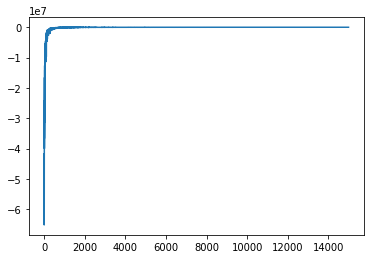

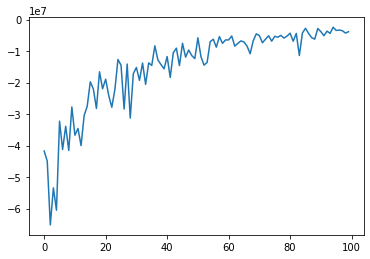

/tmp/ipykernel_3322/731664744.py:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mae =  lambda x,y: torch.abs(torch.tensor(x).to(device)-torch.tensor(y).to(device)).mean()
/tmp/ipykernel_3322/731664744.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse =  lambda x,y: torch.sqrt(((torch.tensor(x).to(device)-torch.tensor(y).to(device) )**2).mean())


(2049, 2048)


100%|██████████| 15000/15000 [00:15<00:00, 961.26it/s] 


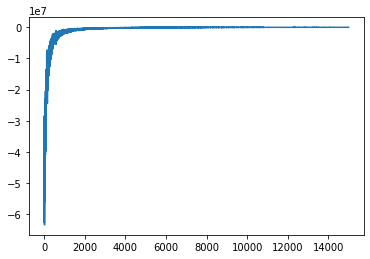

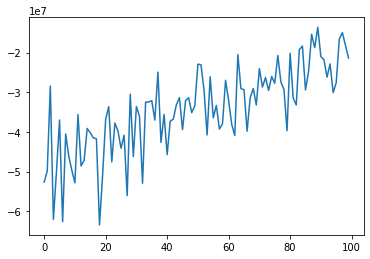

(2049, 2048)


100%|██████████| 15000/15000 [00:16<00:00, 935.29it/s]


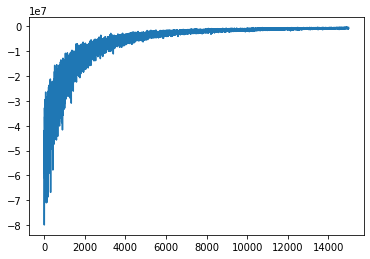

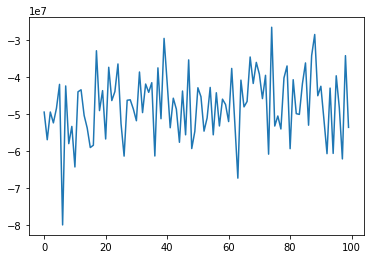

(2049, 2048)


100%|██████████| 15000/15000 [00:15<00:00, 992.83it/s] 


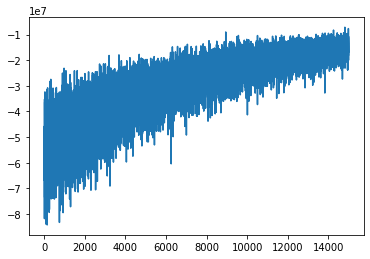

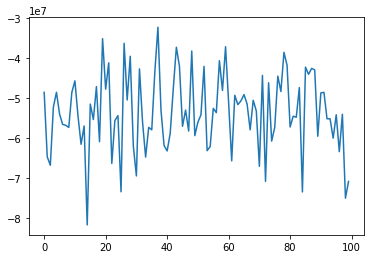

In [137]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import pyro
import pyro.contrib.gp as gp

import time

class SimpleForwardNetBN(AbstractDrift):

    def __init__(self, input_dim=1, width=20):
        super(SimpleForwardNetBN, self).__init__()

        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), torch.nn.Softplus(),
            torch.nn.Linear(width, input_dim)
        )
        
        self.nn[-1].weight.data.fill_(0.0)
        self.nn[-1].bias.data = 15.0 * self.nn[-1].bias.data / torch.std(self.nn[-1].bias.data ) 
        

def train(X_train, y_train, gamma, dim, n_steps, data_batch_size, param_batch_size, dt=0.05, stl=False, size_list=None):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        optimizer.zero_grad()
        
        partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch, size_list=size_list)
#         import pdb; pdb.set_trace()
        loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        if stl: # double check theres no references left
            sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
    
    losses = np.array(losses)
    
    return sde, losses

def lin_reg_data_gen(dim, sigma_n, device, num_samps=30):

    w = np.ones((dim,1))
    b = 1.0

    func = lambda x: np.dot(x, w)  + b

    # Test inputs
    num_test_samples = 30

    if dim == 1:
        X_test = np.linspace(-16, 16, num_samps).reshape(num_samps,1)
        X_train = np.linspace(-3.5, 3.5, num_samps).reshape(-1,1)
    else:
        X_test  = np.random.randn(num_samps, dim)
        X_train  = np.random.randn(num_samps, dim)

    # Noise free training inputs

    #f_train = np.cos(X_train) 
    f_train = func(X_train)

    # Noise-free training outputs
    #f = np.cos(X_test)
    f = func(X_test)
    y_test  = f

    # Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)

    mu = np.zeros(X_train.shape[0])
    
    epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.shape[0]))

    y_train = f_train + epsilon.reshape(X_train.shape[0],1)

    
    return X_train, y_train, X_test, y_test, f

# gamma = 0.1**2
gamma = 0.1**2
sigma2 = 1
sigma_n = 0.2

n_steps = 300
data_batch_size = 50
param_batch_size = 32
samps_lost = []

errors = []

samp_no = 100


def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params, size_list=None):
    preds = func_model(functional.get_params_from_array(params, size_list), x)

    diff = preds - y
    
    return - torch.sum(diff**2) / (2 * sigma_n**2)

def log_likelihood_batch(x, y, params_batch, size_list=None):
    func = lambda params: log_likelihood(x, y, params, size_list=size_list)
    func = functorch.vmap(func)
    return func(params_batch)

def log_posterior(x, y, params, size_list=None):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params, size_list=size_list)

def log_posterior_batch(x, y, params_batch, size_list=None):
    func = lambda params: log_posterior(x, y, params, size_list=size_list)
    func = functorch.vmap(func)
    return func(params_batch)


start, end = 6, 10
dt=0.01
for i in range(start,end):
    dim = dim_data =  2**11
    
    step_ = 10**(-i)


    X_train, y_train, X_test, y_test, f = lin_reg_data_gen(dim,  sigma_n, device, num_samps=dim+1)
    print(X_train.shape)

    N_train , _ = X_train.shape
    N_test , _ = X_test.shape
    
    X_train = torch.tensor(X_train, device=device, dtype=torch.float)
    X_test = torch.tensor(X_test, device=device, dtype=torch.float)

    y_train = torch.tensor(y_train, device=device, dtype=torch.float)
    y_test = torch.tensor(y_test, device=device, dtype=torch.float)
    
    
#     ################################ GP #################################################################
#     kernel = gp.kernels.Linear(input_dim=dim, variance=torch.tensor(1.0) )
# #     kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
# #     import pdb;pdb.set_trace()
#     gpr = gp.models.GPRegression(X_train, y_train.reshape(-1), kernel, noise=torch.tensor(0.2**2) )
#     f_loc, f_cov = gpr(X_test, full_cov=False)
#     gp_std = torch.sqrt(f_cov)
#     gp_mean = f_loc
    
    
    ################################  N-SFS #########################################################
    model = LinModel(input_dim=dim).to(device)
    func_model, params = functorch.make_functional(model)
    size_list = functional.params_to_size_tuples(params)
    dim_mod = functional.get_number_of_params(size_list)
    
#     sde, losses = train(X_train, y_train, gamma, dim_mod, n_steps, data_batch_size, param_batch_size, size_list=size_list)
#     test_samp_nsfs_start = time.time()
#     param_samples = sde.sample(samp_no, dt=dt, device=device)
#     test_samp_nsfs_delta = (time.time() - test_samp_nsfs_start) / 60.0
#     std, mean, logp, mse = predict(param_samples, X_test, y_test, size_list=size_list)
#     std = torch.sqrt(std**2 + sigma_n**2)
    
#     ################################  SFS ############################################################
#     sde_sfs = MCFollmerSDE(torch.tensor(gamma), dim_mod, log_posterior, X_train, y_train, device, size_list=size_list)
#     test_samp_sfs_start = time.time()
#     sfs_samps = sde_sfs.sample(samp_no, dt=dt, device=device)
#     test_samp_sfs_delta = (time.time() - test_samp_sfs_start) / 60.0
#     sfs_samps = sfs_samps[~torch.isnan(sfs_samps).sum(dim=1).bool()]
#     std_sfs, mean_sfs, logp_sfs, mse_sfs = predict(sfs_samps, X_test, y_test, size_list=size_list)
#     std_sfs = torch.sqrt(std_sfs**2 + sigma_n**2)
    
#     samps_lost.append(((torch.isnan(sfs_samps).sum(dim=1).bool()).sum(), samp_no) )
    
    
    ################################ SGLD #############################################################
    
    sgld_param_samples, sgld_losses = sgld(dim_mod, 15000, 5000, data_batch_size, X_train, y_train, size_list=size_list, step_size= step_)
    
    std_sgld, mean_sgld, logp_sgld, mse_sgld = predict(sgld_param_samples[:5000], X_test, y_test, size_list=size_list)
    std_sgld = torch.sqrt(std_sgld**2 + sigma_n**2)
    
    plt.plot(sgld_losses)
    plt.show()
    
    plt.plot(sgld_losses[:100])
    plt.show()
    
    
    
    ################################  True ############################################################
    std_true = pred_true_std(X_train, X_test, sigma_n,  sigma2, dim_mod)
    mean_true = pred_true_mean(y_train.detach().cpu(), X_train, X_test, sigma_n,  sigma2, dim_mod)
    
    
    
    ################################  Errors ############################################################
    
    mae =  lambda x,y: torch.abs(torch.tensor(x).to(device)-torch.tensor(y).to(device)).mean()
    mse =  lambda x,y: torch.sqrt(((torch.tensor(x).to(device)-torch.tensor(y).to(device) )**2).mean())
    
    errors.append(
        {
            "mae_sfs_mean": mae(mean_sfs, mean_true),
            "mae_nsfs_mean": mae(mean, mean_true),
            "mse_sfs_mean": mse(mean_sfs, mean_true),
            "mse_nsfs_mean": mse(mean, mean_true),
            "mae_sfs_std": mae(std_sfs, std_true),
            "mae_nsfs_std": mae(std, std_true),
            "mse_sfs_std": mse(std_sfs, std_true),
            "mse_nsfs_std": mse(std, std_true),
            "sfs_stats": (mean_sfs, std_sfs),
            "mae_sgld_std": mae(std_sgld, std_true),
            "mae_sgld_mean": mae(mean_sgld, mean_true),
            "sgld_stats": (mean_sgld, std_sgld),
            "nsfs_stats": (mean, std),
            "true_stats": (mean_true, std_true),
            "gp_stats": (None, None), # (gp_mean, gp_std)
            "test_times": (test_samp_nsfs_delta, test_samp_sfs_delta)
        }
    )

In [141]:
x_ax  = [2**x for x in range(start, end)]

mae_sfs_mean = [x["mae_sfs_mean"].item() for x in errors]
mae_nsfs_mean = [x["mae_nsfs_mean"].item() for x in errors]
mae_sgld_mean = [x["mae_sgld_mean"].item() for x in errors]

mae_sfs_std = [x["mae_sfs_std"].item() for x in errors]
mae_nsfs_std = [x["mae_nsfs_std"].item() for x in errors]
mae_sgld_std = [x["mae_sgld_std"].item() for x in errors]

In [142]:
mae_sgld_std, mae_sgld_mean

([2.291833800519971, 2.382034543307325, 2.0770499293290907, 2.054851202575822],
 [5.007766672346962, 9.407434164793623, 16.47395251721641, 28.420384448886455])

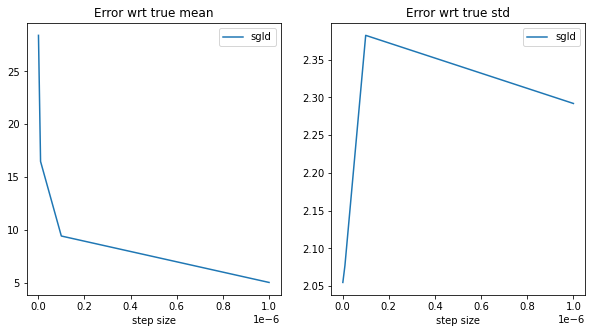

In [143]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

x_ax  = [10**(-x) for x in range(start, end)]

# ax1.plot(x_ax, mae_nsfs_mean, label="n-sfs")
# ax1.plot(x_ax, mae_sfs_mean, label="mc-sfs")
ax1.plot(x_ax, mae_sgld_mean, label="sgld")
ax1.set_xlabel("step size")

ax1.set_title("Error wrt true mean")
ax1.legend()


# ax2.plot(x_ax ,mae_nsfs_std, label="n-sfs")
# ax2.plot(x_ax, mae_sfs_std, label="mc-sfs")
ax2.plot(x_ax, mae_sgld_std, label="sgld")
ax2.set_xlabel("step size")
ax2.set_title("Error wrt true std")
ax2.legend()

In [100]:
mae_sgld_std

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [109]:
sfs_means = [x["sfs_stats"][0].mean().item() for x in errors]
nsfs_means = [x["nsfs_stats"][0].mean().item() for x in errors]
sgld_means = [x["sgld_stats"][0].mean().item() for x in errors]
true_means = [x["true_stats"][0].mean().item() for x in errors]
# gp_means = [x["gp_stats"][0].mean().item() for x in errors]

sfs_stds = [x["sfs_stats"][1].mean().item() for x in errors]
nsfs_stds = [x["nsfs_stats"][1].mean().item() for x in errors]
true_stds = [x["true_stats"][1].mean().item() for x in errors]
sgld_stds = [x["sgld_stats"][1].mean().item() for x in errors]
# gp_stds = [x["gp_stats"][1].mean().item() for x in errors]

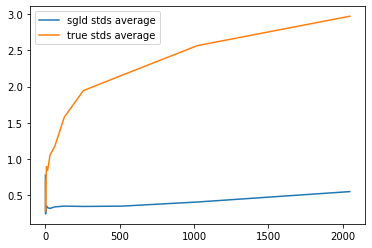

In [113]:
# plt.plot(x_ax, nsfs_stds, label="n-sfs stds average")
# plt.plot(x_ax, sfs_stds, label="sfs stds average")
plt.plot(x_ax, sgld_stds, label="sgld stds average")
plt.plot(x_ax, true_stds, label="true stds average")
plt.legend()

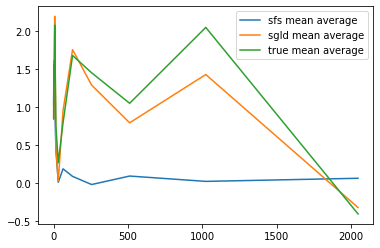

In [112]:
# plt.plot(x_ax, nsfs_means, label="n-sfs mean average")
plt.plot(x_ax, sfs_means, label="sfs mean average")
plt.plot(x_ax, sgld_means, label="sgld mean average")
plt.plot(x_ax, true_means, label="true mean average")
plt.legend()

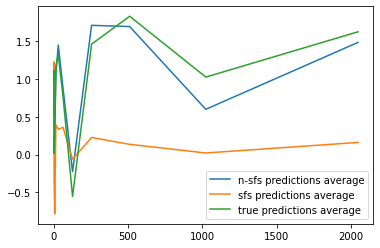

In [68]:
plt.plot(x_ax, nsfs_means, label="n-sfs predictions average")
plt.plot(x_ax, sfs_means, label="sfs predictions average")
plt.plot(x_ax, true_means, label="true predictions average")
plt.legend()

In [69]:
# sfs_times = [x["test_times"][1] for x in errors]
# nsfs_times = [x["test_times"][0] for x in errors]

# plt.plot(x_ax, nsfs_times, label="n-sfs test time minutes")
# plt.plot(x_ax, sfs_times, label="sfs test time minutes")
# plt.legend()